## Synthetic data for supernovae compilations

#### In this notebook, we train an ANN with supernovae compitation.  In order to deal with the covariance matrix, we test two differents ways:

1) Add the statistical errors at the covariance matrix $\Sigma$ of the systematic errors of JLA and Pantheon supernovaes compilation. Then, we use the fact that $\Sigma$ is symmetrical and we can to use the spectral theorem: $\Sigma = P D P^T$

  and we add $D$ to the dataset to train a neural network as a feature instead the statistical error. 
  When we make predictions, we need to take a subspace of the original eigenvector matrix P and obtain a new covariance matrix.
  
 2) We don't use any properties of the matrix, only train ANN with z, $D_L$ and the statistical error. When we make predictions, we take any submatrix of the original covariance matrix.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### Read the JLA covariance matrix

In [2]:
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### This matrix have sigly difference in the out diagonal elements, we fix it:

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Now, load the data (redshift, $D_L$ and statistical errors)

In [4]:
file = 'data/pantheon.txt'
# file = 'data/jla_lcparams.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
staterr = data.values[:,2]

### For method 1: Adding statistical error to the covariance matrix and vizualize it:

In [5]:
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)

(1048, 1048) (1048, 1048)


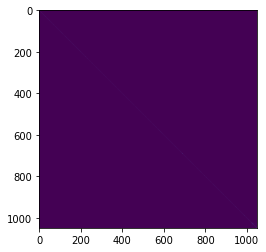

In [6]:
plt.imshow(covfull)

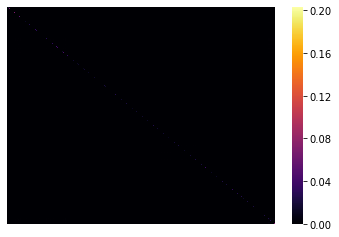

In [7]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False)

### Calculate eigenvalues and eigenvectors of the new covariance matrix:

(1048,) (1048, 1048)


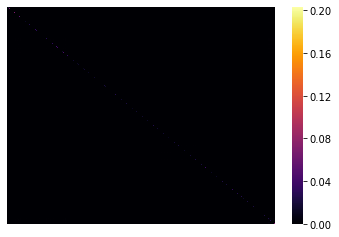

In [8]:
eigenval, eigenvec = sp.linalg.eigh(covfull)
print(np.shape(eigenval), np.shape(eigenvec))
rec_cov = np.matmul(eigenvec, np.diag(eigenval))
rec_cov = np.matmul(rec_cov, np.transpose(eigenvec))
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False)


### Verify that there are not complex values:

In [9]:
count = 0

for i in range(len(eigenvec)):
    for j in range(len(eigenvec)):
        if np.iscomplex(eigenvec[i,j]):
            count+=1

print(count)

0


### Generation of the data to feed the neural network.

#### We need z, $D_L$ and the eigenvalues

In [10]:
X = data[['zcmb']].values
# scalerx = MinMaxScaler(feature_range=(-1,1))
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))
# print(data[['mb']].values)

dl = np.reshape(data[['mb']].values, (len(X), 1))
# scalerdl = MinMaxScaler(feature_range=(-1,1))
# scalerdl.fit(dl.reshape(-1,1))
# dl = scalerdl.transform(dl.reshape(-1,1))



err = np.reshape(data[['dmb']].values, (len(X), 1))
eigenval= np.reshape(eigenval, (len(X), 1))

# scalereig = MinMaxScaler(feature_range=(-1,1))
# scalereig.fit(eigenval.reshape(-1,1))
# eigenval = scalereig.transform(eigenval.reshape(-1,1))

Y = np.concatenate((dl, eigenval), axis=1)

Y = np.concatenate((Y, err), axis=1)
print(np.shape(X), np.shape(Y))





(1048, 1) (1048, 3)


### Shuffle data and split in test and trainning set

In [11]:
shuffle = [x for x in range(len(X)) if x%2 ==1]
comp = [x for x in range(len(X)) if x%2 ==0]
shuffle.extend(comp)
split = 0.8

X = X[shuffle]
Y = Y[shuffle]

ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
Y_train, Y_test = np.split(Y, indx)
max(X)

array([2.26])

### Define a model and some hyperparameters:

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0001,
                                   patience=100,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = tf.keras.initializers.RandomNormal() 

def model(input_x):
    efirst = Dense(300, activation='relu', input_shape=(1,))(input_x)
    ehidden = Dense(100, activation='relu')(efirst)
    ehidden2 = Dense(300, activation='relu')(ehidden)
    elast = Dense(3, activation='linear')(ehidden2)
    return elast

batch_size = 8
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 300)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 61,903
Trainable params: 61,903
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_train = neural_model.fit(X_train, Y_train, batch_size=batch_size,
                                    epochs=epochs, verbose=1,
                                    validation_data=(X_test, Y_test),
                                    callbacks=callbacks)

Epoch 1/500
105/105 [==============================] - 0s 4ms/step - loss: 46.8380 - val_loss: 5.5643
Epoch 2/500
105/105 [==============================] - 0s 3ms/step - loss: 1.8803 - val_loss: 2.3650
Epoch 3/500
105/105 [==============================] - 0s 2ms/step - loss: 0.6612 - val_loss: 1.1588
Epoch 4/500
105/105 [==============================] - 0s 2ms/step - loss: 0.4986 - val_loss: 0.9926
Epoch 5/500
105/105 [==============================] - 0s 2ms/step - loss: 0.4739 - val_loss: 1.0130
Epoch 6/500
105/105 [==============================] - 0s 3ms/step - loss: 0.4527 - val_loss: 1.0691
Epoch 7/500
105/105 [==============================] - 0s 2ms/step - loss: 0.4077 - val_loss: 0.8047
Epoch 8/500
105/105 [==============================] - 0s 2ms/step - loss: 0.3915 - val_loss: 0.7318
Epoch 9/500
105/105 [==============================] - 0s 3ms/step - loss: 0.3219 - val_loss: 0.6091
Epoch 10/500
105/105 [==============================] - 0s 2ms/step - loss: 0.2988 - val_l

Epoch 161/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0453
Epoch 162/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0316
Epoch 163/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0252
Epoch 164/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0218 - val_loss: 0.0410
Epoch 165/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0667
Epoch 166/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0401
Epoch 167/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.0420
Epoch 168/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0267 - val_loss: 0.0530
Epoch 169/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0690
Epoch 170/500
105/105 [==============================] - 0s 2ms/step - lo

105/105 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0240
Epoch 320/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0777
Epoch 321/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.0481
Epoch 322/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0225
Epoch 323/500
105/105 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0233
Epoch 324/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 325/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0203
Epoch 326/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0321
Epoch 327/500
105/105 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0234
Epoch 328/500
105/105 [==============================] - 0s 3ms/step - loss: 0.0241 - v

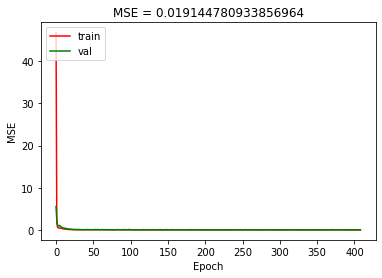

In [14]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE = {}'.format(np.min(model_train.history['val_loss'])))
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_pantheon.png", dpi=200)

In [15]:
# ranz = np.random.uniform(0, 2, size=100)
ranz = np.linspace(0.01, 2.3, 100)
pred_random = neural_model.predict(ranz)
# pred_random
np.shape(pred_random[:, 1])

(100,)

### Method 1: Now we can construct a covariance matrix of lower dimension generating the eigenvalues for the new subspace and using a cutted matrix from the eigenvector orthonormalized matrix that this should be a base of the subspace.

In [16]:
new_D = np.diag(pred_random[:, 1])
print(np.shape(new_D))
subspaceDim = len(new_D)
reduce_eigenvec = eigenvec[:subspaceDim, :subspaceDim]
print(subspaceDim)
trans_eigenvec = np.transpose(reduce_eigenvec)
new_cov = np.matmul(reduce_eigenvec, new_D)
new_cov = np.matmul(new_cov, trans_eigenvec)

(100, 100)
100


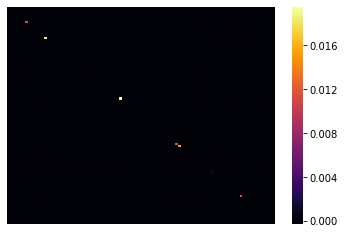

In [17]:
sns.heatmap(pd.DataFrame(new_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

plt.savefig("cov_method1.png")

In [18]:
np.savetxt("pantheoncov_method1_nn.txt", new_cov.reshape(100*100), delimiter= " ", header="#100 100")

In [19]:
mookSN = np.concatenate((ranz.reshape(-1,1), pred_random[:,:2]), axis=1)
np.savetxt("pantheonDATA_method1_nn.txt", mookSN, delimiter= " ", header="#z dm err")